# Plot comparison between $M_0$ and $T_{hold}$

Plot the comparison to evaluate the time healing of the friction on the gouge patch.

2025.01.05 Kurama Okubo

In [21]:
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from matplotlib import ticker

%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns
import copy

import scipy.io as sio
from scipy.signal import decimate

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = False #True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# datadir = "../data/M0vsThold/"
# if not os.path.exists(datadir):
#     os.makedirs(datadir)

figdir = "../figure/M0vsThold/"
if not os.path.exists(figdir):
    os.makedirs(figdir)


In [23]:
expr_id = 87

In [24]:
# Load macroscopic data
fi_macroscropic = "../../../Experiments/MacroData/data/MacroData_raw.mat"
fi_macro = sio.loadmat(fi_macroscropic, squeeze_me=False)

In [25]:
# fi_macro
tvec_macro = np.squeeze(fi_macro["M"][f"FB03_{expr_id:03d}"][0][0]["tmat"][0][0])
SS = np.squeeze(fi_macro["M"][f"FB03_{expr_id:03d}"][0][0]["SS"][0][0])
NP = np.squeeze(fi_macro["M"][f"FB03_{expr_id:03d}"][0][0]["NP"][0][0])
dt_macro = tvec_macro[1] - tvec_macro[0]

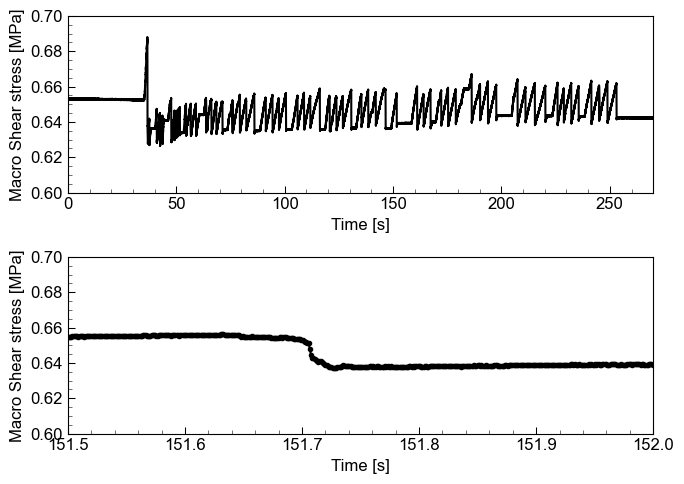

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

ax1.plot(tvec_macro, SS, "k-")
ax1.set_xlim([0, 270])
ax1.set_ylim([0.6, 0.7])
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Macro Shear stress [MPa]")

ax2.plot(tvec_macro, SS, "k.-")
ax2.set_xlim([151.5, 152])
ax2.set_ylim([0.6, 0.7])
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Macro Shear stress [MPa]")

fig.tight_layout()

# Plot gouge events and the macroscopic stress

In [27]:
# read gouge event catalog
gougepatch_id = "G3"
Qinv_quart = 50

Nvalidsensors_thresh = 4

finame = f"../../../GougeEventCatalog/data/gougeeventcatalog__fb03-{expr_id:03d}__{gougepatch_id}__Q{Qinv_quart}.csv"
df_gc = pd.read_csv(finame, index_col=0)
df_gc_selected = df_gc[df_gc["Nvalidsensors"] >= Nvalidsensors_thresh].copy()
df_gc_selected.head()

,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
event_id,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07
9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07
18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07
19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07
20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07


In [28]:
len(df_gc_selected)

33

In [29]:
# Decimate the SS to clean the line plot and to reduce file size
# decimate 100 times

# NOTE: signal.decimate applies an anti-aliasing filter, which changes the offset in our data set as it contains the unloading part.
# Therefore, we simply decimate the data by plot step instead of using the signal.decimate.
# The result is nealy identical and no problem in the comparison.

# tvec_macro_decimate = decimate(tvec_macro,10)
# tvec_macro_decimate = decimate(tvec_macro_decimate,10)
# tvec_macro_decimate = tvec_macro[::100]
# SS_decimate = decimate(SS,10)
# SS_decimate = decimate(SS_decimate,10)


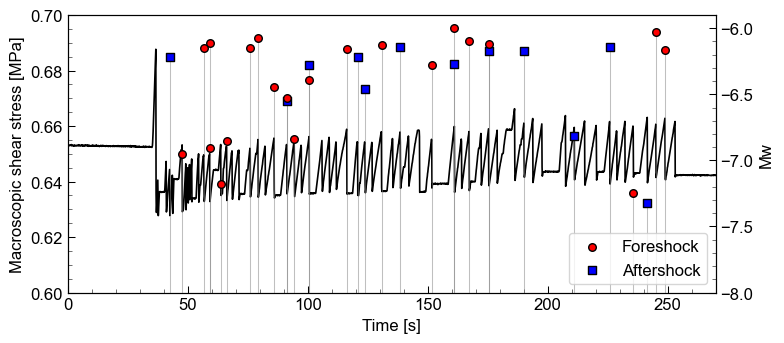

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.6))

plotstep_SS = 100
# ax.plot(tvec_macro, SS, "r-", lw=1)
ax.plot(tvec_macro[::plotstep_SS], SS[::plotstep_SS], "k-", lw=1.2, zorder=4)
# ax.plot(tvec_macro_decimate, SS_decimate+0.015, "b-", lw=1)

ax.set_xlim([0, 270])
ax.set_ylim([0.6, 0.7])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Macroscopic shear stress [MPa]")

ax2 = ax.twinx()

# Plot foreshock
df_gc_fore = df_gc_selected[df_gc_selected["event_label"]=="F"]
df_gc_after = df_gc_selected[df_gc_selected["event_label"]=="A"]

df_gc_fore.plot.scatter(x="event_onset_time", y="Mw", s=30, ax=ax2, color="r", marker="o", edgecolor="k", zorder=3, label="Foreshock")
df_gc_after.plot.scatter(x="event_onset_time", y="Mw", s=30, ax=ax2, color="b", marker="s", edgecolor="k", zorder=2, label="Aftershock")

# plot vertical bars
ylimit2 = [-8.0, -5.9]

for index, row in df_gc_selected.iterrows():
    event_t = row["event_onset_time"]
    Mw = row["Mw"]
    ax2.plot([event_t, event_t], [ylimit2[0], Mw], "-", c="gray", zorder=1, lw=0.75, alpha=0.5)

ax2.set_ylim(ylimit2)
ax2.legend(loc=4)

# plt.suptitle(f'Q{Qinv_quart} water-level={k_waterlevel:.2f}', y=0.98)
plt.tight_layout()

plt.savefig(figdir+f"/M0vsSS_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.png", format="png", dpi=200)
# plt.savefig(figdir+f"/M0vsSS_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.pdf")


# Compute $T_{hold}$

We compute the hold time of the gouge events by the duration from the end of previous stick-slip to the onset of events. For the clarity, we focus only on the foreshocks.

In [31]:
# read the mainshock timing
fi_mainshocktiming = "../../../GougeEventStats/Mainshocktiming/data/MainshockTiming_FB03_087.csv"

df_mainshock = pd.read_csv(fi_mainshocktiming, index_col=0)
df_mainshock.head()

,mainshock_onset_all,mainshock_termination_all,mainshock_duration_all
Stickslip_eventID,,,
1,36.683550,36.720155,0.036605
2,41.028781,41.043626,0.014845
3,42.465061,42.479129,0.014068
4,43.624988,43.638608,0.013620
5,47.665642,47.699931,0.034289


In [32]:
df_gc_selected.head()

,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
event_id,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07
9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07
18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07
19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07
20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07


In [33]:
for event_id, row in df_gc_selected.iterrows():

    if row.event_label == "A":
        t_hold = 0
    else:
        t0 = df_mainshock.loc[row["stickslip_id"]-1, "mainshock_termination_all"]
        t1 = row.event_onset_time
        t_hold = t1-t0

    df_gc_selected.loc[event_id, "t_hold"] = t_hold
    

In [34]:
df_gc_selected.head()

,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std,t_hold
event_id,,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07,0.000000
9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07,4.024085
18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07,2.186817
19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07,2.360146
20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07,2.360497


In [35]:
df_gc_selected.t_hold

event_id
4      0.000000
9      4.024085
18     2.186817
19     2.360146
20     2.360497
21     4.632520
24     2.411018
27     4.685209
31     3.277980
38     3.683535
40     5.290705
43     0.000000
44     3.085974
50     3.217062
52     0.000000
61     4.367211
62     0.000000
69     0.000000
72     3.867294
77     0.000000
85     5.140432
88     9.375315
89     0.000000
95     3.163154
99     3.126571
100    0.000000
109    0.000000
118    0.000000
120    0.000000
126    3.406435
128    0.000000
129    3.562169
131    3.807853
Name: t_hold, dtype: float64

In [36]:
len(df_gc_fore)

21

In [37]:
scatter_mc = sns.color_palette("Set1")
scatter_mc

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [38]:
def M02Mw(M0):
    return (np.log10(M0) - 9.1) * 2.0 / 3.0 # synchronized with OpenSWPC : moment_magnitude ( m0 )

def Mw2M0(Mw):
    return 10**( 1.5 * Mw + 9.05) # synchronized with OpenSWPC : seismic_moment ( mw )
   

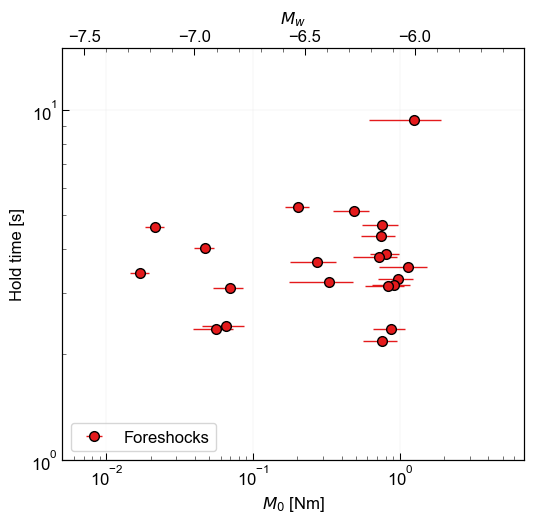

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.4))
mainmarkersize=7

df_gc_fore = df_gc_selected[df_gc_selected["event_label"]=="F"]
# df_gc_fore.plot.scatter(x="t_hold", y="Mw", s=60, ax=ax, color="r", marker="o", edgecolor="k", zorder=3, label="Foreshock")
ax.errorbar(df_gc_fore["M0"].values, df_gc_fore["t_hold"].values, xerr=df_gc_fore["M0_std"].values,
           capsize=0, fmt="o", markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "k", label="Foreshocks", zorder=3)


ax.set_xlabel("$M_0$ [Nm]")
# ax.set_ylabel("Macroscopic Δτ [MPa]")
ax.set_ylabel("Hold time [s]")

ax.set_xscale('log')
ax.set_yscale('log')

xlimit_scaling = [5e-3, 7]
ax.set_xlim(xlimit_scaling)
ax.set_ylim([1, 15])

# ax.set_yticks(np.arange(20, 60, 10))
# ax.set_yticklabels(np.arange(20, 60, 10))

# plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
# plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

ax.legend(loc=3)


#-----------------------#
#--- plot double axis---#
#-----------------------#

# https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
ax2 = ax.twiny()
ax2.set_xlabel("$M_w$")
ax2.set_xlim([M02Mw(xlimit_scaling[0]), M02Mw(xlimit_scaling[1])]) # synchronize with the first axis

# major tick
newlabel = np.array([-7.5, -7, -6.5, -6.0,])
ax2.minorticks_on()
ax2.set_xticks(newlabel)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

plt.tight_layout()

plt.savefig(figdir+f"/M0vsThold_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.png", format="png", dpi=200)
# plt.savefig(figdir+f"/M0vsThold_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.pdf")
